# Random Forest Classifier

## Configuration

In [1]:
import pandas as pd
import plotly.express as px

from IPython.display import Image

from ts_clf_event.data_handler.utils import split_data_time_based
from ts_clf_event.model.model import ModelPipeline
from ts_clf_event.model.evaluator import Evaluator

## Time-based split: Create a "gold" ground truth

In [2]:
data_path = "/Users/georgebatsis/Documents/Projects/ts_clf_event/data/test_dataframe.csv"
test_size_percent = 0.2
label_col = "process"

dev_df, test_df = split_data_time_based(data_path, test_size_percent, label_col)

Number of data points in train set: 69549
Number of data points in test set: 17387
Class distribution in train set: process
0    66363
1     3186
Name: count, dtype: int64
Class distribution in test set: process
0    16334
1     1053
Name: count, dtype: int64
Time in train set: 2020-06-01 00:00:00 to 2020-06-25 12:03:55
Time in test set: 2020-06-25 12:04:56 to 2020-07-01 23:59:37


## Model pipeline

In [3]:
windows = "auto"
features_to_roll = ["value", "level", "frequency", "speed"]
diff_lags = [1, 2]

x_train = dev_df.drop("process", axis=1)
y_train = dev_df["process"]

model_pipeline = ModelPipeline(
    windows=windows,
    features_to_roll=features_to_roll,
    diff_lags=diff_lags,
    features_to_diff=features_to_roll,
    groupby_col="provider",
    params=None # We will use GridSearchCV to find them.
)

model_pipeline.pipeline

Model parameters: None


Pipeline(steps=[('feature_engineering',
                 FeatureEngineeringTransformer(diff_lags=[1, 2],
                                               features_to_diff=['value',
                                                                 'level',
                                                                 'frequency',
                                                                 'speed'],
                                               features_to_roll=['value',
                                                                 'level',
                                                                 'frequency',
                                                                 'speed'],
                                               windows='auto')),
                ('imputer', DataFrameTransformer(transformer=SimpleImputer())),
                ('scaler', DataFrameTransformer(transformer=MinMaxScaler())),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

### Grid Search with K-Fold cross validation

In [4]:
model_pipeline.train(
        x_train,
        y_train,
        tune_hyperparameters=True,
        n_splits=5,
)

Model parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [5]:
ModelPipeline.process_cv_results(model_pipeline.cv_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_precision_pos,std_test_precision_pos,mean_test_recall_pos,std_test_recall_pos,mean_test_f1_pos,std_test_f1_pos
0,4.653633,2.239466,0.138183,0.008583,"{'model__class_weight': None, 'model__max_dept...",0.993291,0.006210,0.993391,0.006091,0.993193,0.006324,0.968661,0.015762,0.911562,0.075249,0.937907,0.044641
1,4.691385,2.234542,0.151294,0.019372,"{'model__class_weight': None, 'model__max_dept...",0.993304,0.005992,0.993374,0.005876,0.993180,0.006108,0.966708,0.020427,0.911878,0.074948,0.936824,0.041530
2,2.471642,1.144400,0.129025,0.009060,"{'model__class_weight': None, 'model__max_dept...",0.993179,0.006095,0.993288,0.005971,0.993099,0.006193,0.965128,0.018092,0.911286,0.073138,0.936220,0.044265
3,1.429291,0.671572,0.120431,0.007543,"{'model__class_weight': None, 'model__max_dept...",0.992955,0.006200,0.993064,0.006078,0.992847,0.006323,0.966068,0.017244,0.905431,0.078828,0.933254,0.047032
4,4.633271,2.221647,0.139555,0.010154,"{'model__class_weight': None, 'model__max_dept...",0.993077,0.005872,0.993115,0.005735,0.992937,0.005967,0.959600,0.034969,0.911277,0.071916,0.932866,0.040029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.810310,0.515965,0.158340,0.035549,"{'model__class_weight': 'balanced', 'model__ma...",0.987067,0.006515,0.985558,0.006668,0.986051,0.006547,0.790662,0.066824,0.924940,0.056403,0.850537,0.047399
158,1.714969,0.562697,0.165104,0.071238,"{'model__class_weight': 'balanced', 'model__ma...",0.987031,0.006431,0.985506,0.006469,0.986006,0.006384,0.788461,0.062631,0.926389,0.056185,0.849988,0.045102
159,1.414728,0.633521,0.117914,0.008276,"{'model__class_weight': 'balanced', 'model__ma...",0.987060,0.006401,0.985523,0.006479,0.986023,0.006380,0.788962,0.066152,0.925734,0.056727,0.849789,0.046225
160,1.576902,0.717516,0.181621,0.088991,"{'model__class_weight': 'balanced', 'model__ma...",0.986964,0.006500,0.985420,0.006557,0.985926,0.006465,0.787934,0.064070,0.925952,0.056544,0.849431,0.046010


#### Analysis

*   **Overall High Performance:** The model achieves very high precision, recall, and F1-scores across all folds, both for the weighted average and for the positive class specifically. This indicates that the model is performing exceptionally well on the training data.
*   **Best Hyperparameters:** The best hyperparameter combination found by `GridSearchCV` is:
    *   `model__class_weight`: `None` (meaning no specific class weighting).
    *   `model__max_depth`: `20`
    *   `model__min_samples_leaf`: `1`
    *   `model__min_samples_split`: `2`
    *   `model__n_estimators`: `200`
*   **Relatively Consistent Performance:** The standard deviations of the metrics across folds are relatively low, suggesting that the model's performance is stable and not highly sensitive to the specific training/validation split.
*   **Balanced vs. None for `class_weight`:** Interestingly, the best model found by `GridSearchCV` does not use class weighting, even though the dataset has an imbalance between the positive and negative classes. This might suggest that the features we've engineered are strong that they allow the model to distinguish between the classes effectively even without explicit class weighting.
*   **Computational Cost:** The `mean_fit_time` values show that training the model with different hyperparameter combinations can take a considerable amount of time (up to several seconds per fold). This highlights the importance of saving the best hyperparameters and reusing them to avoid retraining from scratch every time.

### Training

Train the model with the best hyper-parameters and using all the training subset.

In [6]:
model_pipeline.train(
        x_train,
        y_train,
        tune_hyperparameters=False,
)

Windows for 1: [60, 90, 120]
Windows for 2: [60, 90, 120]


In [7]:
# Save the model
model_pipeline.save_model("RF_model")

### Evaluation on the test subset

In [8]:
model_pipeline.load_model("RF_model")
x_test = test_df.drop("process", axis=1)
y_test = test_df["process"]
y_pred_prob = model_pipeline.predict_proba(x_test)

In [9]:
test_res = Evaluator().report_metrics(y_test, y_pred_prob[:, 1], threshold=0.5)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative               16185                 149
Actual Positive                  54                 999
Macro-averaged Metrics:
  Precision (Macro):   0.9334418656595845
  Recall (Macro):   0.969797936034008
  F1-Score (Macro):   0.9507685201769491
 Positive Class Metrics:
  Precision ( Positive):   0.8702090592334495
  Recall ( Positive):   0.9487179487179487
  F1-Score ( Positive):   0.9077691958200818
Imbalance-Aware Metrics:
  Matthews Correlation Coefficient (MCC):   0.9025078257336112
  Balanced Accuracy:   0.969797936034008
  Average Precision (AP):   0.9794653926774064
  Area Under ROC Curve (AUROC):   0.9984199726251071
  Recall@Precision=0.5:   1.0


#### Analysis

The model performs exceptionally well on the test set, with high precision, recall, and F1-score for both the macro average and the positive class. According to the Confusion Matrix, the model only misclassified 54 actual positive instances as negative. This is important in a scenario where missing a positive case could have significant consequences (e.g., failing to detect a critical event). The model has 149 false positives, meaning it incorrectly classified 149 negative instances as positive. MCC `0.903` is very high, close to 1, indicates excellent performance considering class imbalance. Also, the Balanced Accuracy `0.970`, indicated a good measure for imbalanced datasets. Average Precision (AP) `0.979` indicates good performance on the positive class and with a Area Under ROC Curve (AUROC) `0.998` indicated excellent ability to distinguish between classes.

### Model Interpetability

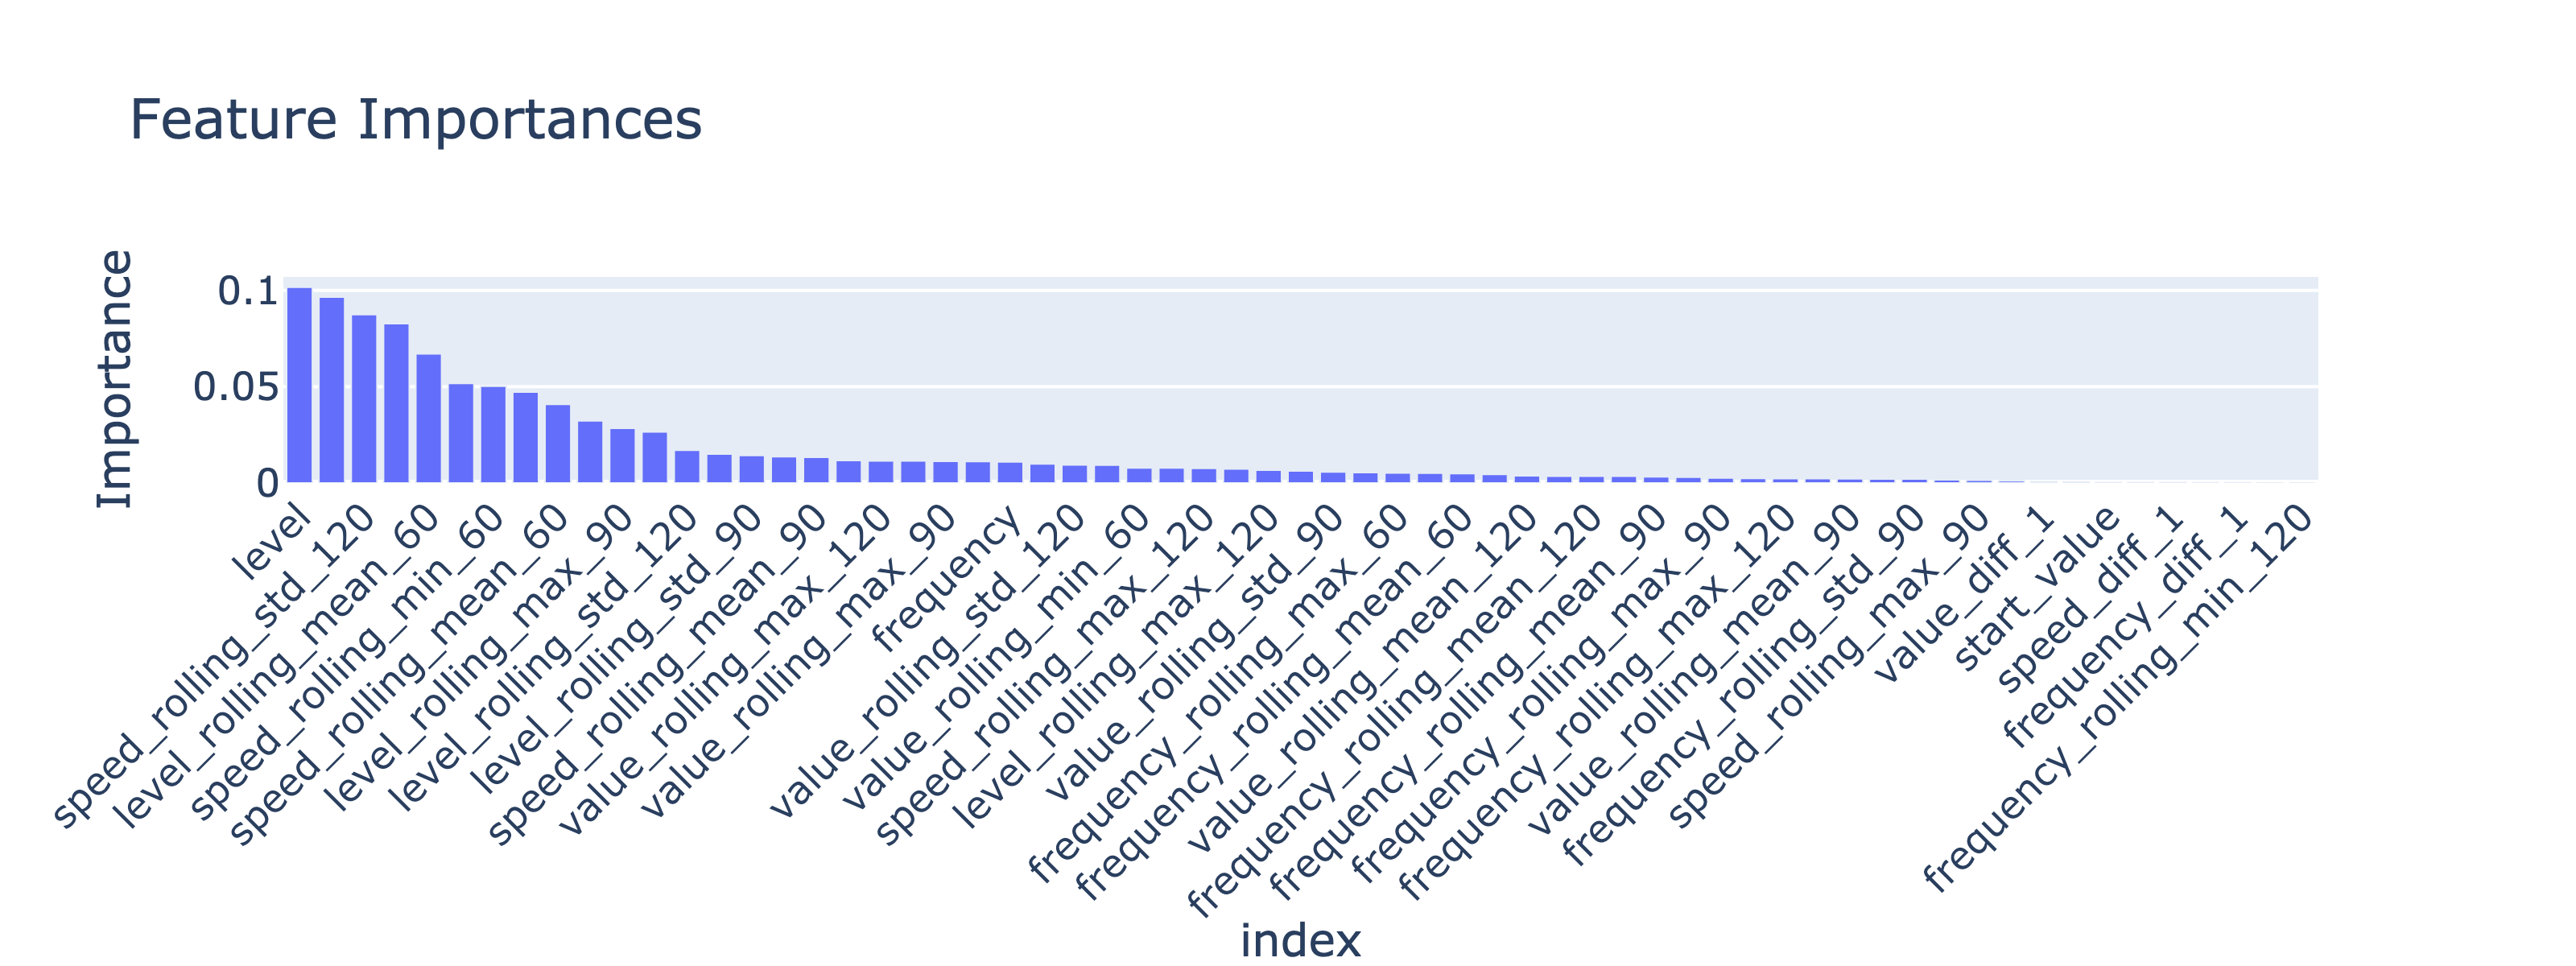

In [10]:
importances = model_pipeline.pipeline.named_steps['model'].feature_importances_
feature_names = model_pipeline.pipeline.named_steps['feature_engineering'].feature_list

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig = px.bar(
    feature_importances,
    x=feature_importances.index,
    y=feature_importances.values,
    labels={'x': 'Feature', 'y': 'Importance'},
    title='Feature Importances'
)

fig.update_layout(xaxis_tickangle=-45)

Image(fig.to_image(format="png", width=800, height=300, scale=4))

In [11]:
feature_importances

level                        0.101637
speed                        0.096572
speed_rolling_std_120        0.087483
value                        0.082712
level_rolling_mean_60        0.067028
                               ...   
speed_diff_1                 0.000195
frequency_rolling_min_60     0.000153
frequency_diff_1             0.000101
frequency_rolling_min_90     0.000044
frequency_rolling_min_120    0.000000
Length: 63, dtype: float64

The feature importances indicate that `level` (0.102), `speed` (0.097), and `speed_rolling_std_120` (0.087) are the most influential predictors, followed by `value` (0.083) and `level_rolling_mean_60` (0.067). This suggests that the raw `level` and `speed` values, as well as the variability of `speed` over a 120-unit window and the central tendency of `level` over a 60-unit window, are crucial for the model's predictions. Engineered features based on rolling statistics generally outweigh raw features and simple difference features (`_diff_`), with features like `frequency_rolling_min_` having virtually no importance.